# **Case study**: Reed breast leukocyte data

This notebook contains instructions and code to reproduce our case study with a [Human Breast Cell Atlas leukocyte dataset](https://cellxgene.cziscience.com/collections/48259aa8-f168-4bf5-b797-af8e88da6637):

* Reed AD, Pensa S, Steif A, et al (2024) *A single-cell atlas enables mapping of homeostatic cellular shifts in the adult human breast*. Nature Genetics 56(4):652–662. https://doi.org/10.1038/s41588-024-01688-9, URL https://doi.org/ 10.1038/s41588-024-01688-9

We demonstrate the use of our **general supervised evaluation approaches**, which are complementary to the unsupervised RNX-based Structure Preservation (SP) metrics described in our paper.
Specifically, we apply

* the **Extended Neighbourhood-Proportion-Error (xNPE)** to separately evaluate embedding distortions of labelled cell populations;
* **neighbourhood composition plots (NCPs)** to reveal sources of distortion at different neighbourhood scales.

A *ViVAE* embedding is compared to corresponding embedddings from *t*-SNE and *UMAP*, leveraging known cell population labels **to both quantify and describe sources of distortion**.

<br>
<details>
<summary><b>Why we chose this dataset</b></summary>

This dataset was picked for 3 reasons:

* The data is **non-developmental**: *i.e.*, there is **no expectation of smooth developmental gradients** between cell subsets.
This is specifically as **an alternative to the complementary *Farrell* data case study**.
* It contains labelled **immune cell subtypes from different compartments** (*T cells*, *NK cells*, *B cells*, *dendritic cells*, *macrophages* and *innate lymphoid cells*) that are **familiar to immunologists**.
* We observed that default embeddings of this data from the two most commonly used single-cell DR algorithms (*t*-SNE and *UMAP*) **do not clearly separate out some labelled cell populations** (*e.g.*, a part of the NK-cell subset seems scattered across the T- and NK-cell compartment).
This led us to question **how valid the layout of labelled populations was in each embedding**, and how to evaluate this effectively.

Note that the Farrell case study (see `case_study_farrell.ipynb`) bolsters the case for *ViVAE* with developmental single-cell data (as well as for models with smooth latent spaces more generally).
In contrast to that, **this case study validates the use of *ViVAE* with the more commonly found non-developmental expression data**, evaluating how faithful its layout of labelled populations is compared to input data.

<hr>
</details>
<br>

<details>
<summary><b>Why we use these evaluation metrics</b></summary>

It is apparent that overall **high Local SP** (achieved by *t*-SNE in this case) **is correlated to some extent with separating out relevant cell populations**.

However, we show in our proof-of-concept experiment on evaluation metrics (included as an example in the [ViScore](https://github.com/saeyslab/ViScore) GitHub repository) that **it is sensitive to some types of hyper-local distortions that do not change the relative positions of cell subsets of interest**.

To address this, we extend the previously proposed [Neighbourhood Proportion Error (NPE)](https://github.com/akonstodata/NPE?tab=readme-ov-file) to obtain **xNPE: a novel supervised evaluation metric** that uses population labels to **specifically detect positional distortions per cell population** at a chosen scale (as described in our paper and documentation of the `xnpe` function in *ViScore*).

In addition to this, we create **neighbourhood composition plots (NCPs)**, which is a more straightforward approach to displaying what the neighbourhoods of cell populations look like in inputs space and in each evaluated embedding, thus **not only quantifying distortions but describing them** across a range of neighbourhood sizes.

<hr>
</details>
<br>

<details>
<summary><b>Which methods we compare and why</b></summary>

We chose to compare our *ViVAE* model to *t*-SNE and *UMAP* for 2 reasons:

* They are the two most popular non-linear DR methods in the single-cell field, familiar to a wide range of researchers.
* They are **neighbour-embedding (NE) algorithms**, which are generally expected to do well at separating distinct cell populations due to their locality bias.
This makes them an appropriate choice for the *Reed* dataset.

</details>
<br><hr>

## **0.** Load required modules

To run this notebook, install `vivae`, `viscore` and `umap` into your Python environment.
In terminal:

```bash
pip install git+https://github.com/saeyslab/ViVAE
pip install git+https://github.com/saeyslab/ViScore
pip install umap-learn
```

Then load all required modules as shown below...

In [1]:
import warnings
import os, copy, numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt, torch, scanpy as sc

os.environ['VIVAE_DETERMINISTIC'] = '1'
os.environ['VIVAE_CUDA'] = '0'
os.environ['VIVAE_MPS'] = '0'

import vivae as vv
import viscore as vs
from sklearn.manifold import TSNE
from umap import UMAP

/Users/davidnovak/miniforge3/envs/vivae/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/davidnovak/miniforge3/envs/vivae/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/davidnovak/miniforge3/envs/vivae/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/davidnovak/miniforge3/envs/vivae/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/davidnovak/miniforge3/envs/vivae/lib/python3.11/site-packages/anndata/utils.py:

## **1.** Load input data

We provide **instructions for downloading and pre-processing the data** in the `benchmarking` documentation of the [ViScore](https://github.com/saeyslab/ViScore) GitHub repository.
Once that is done, import the required inputs...

In [2]:
## Assume inputs are saved in ../data

pc    = np.load(os.path.join('..', 'data', 'Reed_input.npy'),          allow_pickle=True) # PCA-transformed expression data
pc_d  = np.load(os.path.join('..', 'data', 'Reed_input_denoised.npy'), allow_pickle=True) # ...denoised
labs  = np.load(os.path.join('..', 'data', 'Reed_labels.npy'),         allow_pickle=True) # population labels
unass = 'unknown' # label for unassigned cells

To be able to **evaluate neighbourhoods of various sizes**, we will generate a *k*-nearest-neighbour graph (*k*-NNG) **for 1000 nearest neighbours**.

The `vs.make_knn` function will construct the graph and save it, or load it if it has been constructed and saved previously...

In [3]:
knn1000 = vs.make_knn(pc, fname=os.path.join('..', 'data', 'Reed_knn1000.npy'), k=1000, random_state=42)

Loading k-NNG


## **2.** Generating embeddings

Let's use *t*-SNE, *UMAP* and *ViVAE* to generate their respective embeddings of this dataset.
We use default hyperparameter values, with denoising for *ViVAE*.
Our paper includes an ablation study on the use of denoising with other models.

Using the `random_state` argument where possible should achieve reproducibility at least across multiple runs on a single machine (with the same GPU/CPU device for *ViVAE*).
If complete reproducibility (*i.e.*, identical results) is not achieved with *ViVAE*, consult [this document](https://pytorch.org/docs/stable/notes/randomness.html) for troubleshooting.

In [4]:
## Train t-SNE model & transform inputs

model_tsne = TSNE(n_components=2, random_state=1)
emb_tsne = model_tsne.fit_transform(pc)
np.save('Reed_emb_tsne.npy', emb_tsne, allow_pickle=True)

In [5]:
## Train UMAP model & transform inputs

model_umap = UMAP(n_components=2, random_state=1)
emb_umap = model_umap.fit_transform(pc)
np.save('Reed_emb_umap.npy', emb_umap, allow_pickle=True)

/Users/davidnovak/miniforge3/envs/vivae/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/davidnovak/miniforge3/envs/vivae/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
## Train ViVAE model & transform inputs

np.random.seed(1)
torch.manual_seed(1)
model_vivae = vv.ViVAE(input_dim=pc.shape[1], latent_dim=2, random_state=1)
model_vivae.fit(pc_d)
emb_vivae = model_vivae.transform(pc_d)
np.save('Reed_emb_vivae.npy', emb_vivae, allow_pickle=True)

Epoch 1/50	recon: 112.6770	kldiv: 2.4128	geom: 0.0000	egeom: 0.0000	mds: 1384.6439	imit: 0.0000
Epoch 2/50	recon: 28.4697	kldiv: 2.1946	geom: 0.0000	egeom: 0.0000	mds: 327.8572	imit: 0.0000
Epoch 3/50	recon: 15.4869	kldiv: 1.5297	geom: 0.0000	egeom: 0.0000	mds: 203.6849	imit: 0.0000
Epoch 4/50	recon: 10.6089	kldiv: 1.1287	geom: 0.0000	egeom: 0.0000	mds: 145.7187	imit: 0.0000
Epoch 5/50	recon: 8.0254	kldiv: 0.8658	geom: 0.0000	egeom: 0.0000	mds: 111.4247	imit: 0.0000
Epoch 6/50	recon: 6.3843	kldiv: 0.9492	geom: 0.0000	egeom: 0.0000	mds: 62.8819	imit: 0.0000
Epoch 7/50	recon: 4.9425	kldiv: 0.9579	geom: 0.0000	egeom: 0.0000	mds: 42.1714	imit: 0.0000
Epoch 8/50	recon: 3.8140	kldiv: 0.8453	geom: 0.0000	egeom: 0.0000	mds: 34.9478	imit: 0.0000
Epoch 9/50	recon: 2.9419	kldiv: 0.7522	geom: 0.0000	egeom: 0.0000	mds: 30.5181	imit: 0.0000
Epoch 10/50	recon: 2.4755	kldiv: 0.6744	geom: 0.0000	egeom: 0.0000	mds: 27.1772	imit: 0.0000
Epoch 11/50	recon: 2.1820	kldiv: 0.5839	geom: 0.0000	egeom: 0.0000	m

In [7]:
## Save generated embeddings

np.save('emb_tsne.npy', emb_tsne, allow_pickle=True)
np.save('emb_umap.npy', emb_umap, allow_pickle=True)
np.save('emb_vivae.npy', emb_vivae, allow_pickle=True)

## **3.** Compute population-level xNPE scores

We use xNPE scoring to quantify misembedding of labelled cell populations using the 1000-nearest-neighbour graph built earlier.

In [8]:
## Compute xNPE

xnpe_tsne  = vs.xnpe(hd=pc, ld=emb_tsne,  annot=labs, knn=knn1000, random_state=42)
xnpe_umap  = vs.xnpe(hd=pc, ld=emb_umap,  annot=labs, knn=knn1000, random_state=42)
xnpe_vivae = vs.xnpe(hd=pc, ld=emb_vivae, annot=labs, knn=knn1000, random_state=42)

In [9]:
## Save xNPE results

np.save('xnpe_tsne.npy',  xnpe_tsne, allow_pickle=True)
np.save('xnpe_umap.npy',  xnpe_umap, allow_pickle=True)
np.save('xnpe_vivae.npy', xnpe_vivae, allow_pickle=True)

## **4.** Plot generated embeddings

Using a palette or more-or-less distinctive colours, we plot the 2-d layouts of the data that we obtained from the three methods.

In [10]:
palette = {
    'CD4-positive helper T cell':                           'sandybrown',
    'CD8-positive, alpha-beta memory T cell':               '#c1c86c',
    'Tc1 cell':                                             '#699dc0',
    'class switched memory B cell':                         '#d889c1',
    'dendritic cell':                                       '#a89ef4',
    'effector memory CD8-positive, alpha-beta T cell':      'firebrick',
    'innate lymphoid cell':                                 '#757469',
    'macrophage':                                           'olive',
    'mature NK T cell':                                     '#87d7d6',
    'naive B cell':                                         '#6afd6e',
    'naive thymus-derived CD4-positive, alpha-beta T cell': 'rebeccapurple',
    'natural killer cell':                                  'chocolate',
    'plasma cell':                                          'black',
    'unknown':                                              '#74c7c0',
    'unswitched memory B cell':                             'goldenrod' 
}

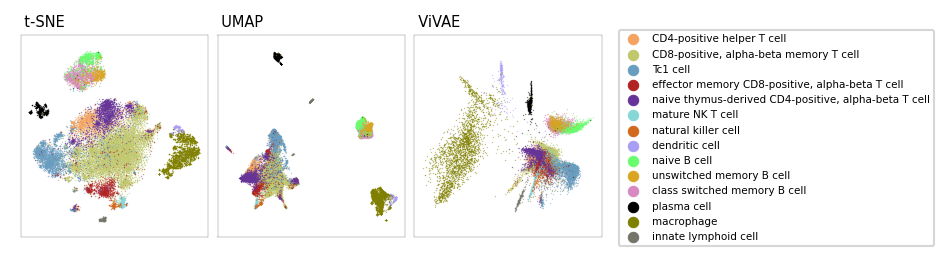

In [11]:
mpl.rcParams['axes.linewidth'] = 0.1
pops = list(palette.keys())
methods = ['t-SNE', 'UMAP', 'ViVAE']
nmet = len(methods)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(5, 1.75), dpi=150)
fig.subplots_adjust(wspace=.05)
handles = []
labels = []
embs = [emb_tsne, emb_umap, emb_vivae]
s = .01
for i, method in enumerate(methods):
        idcs0 = np.where(labs==unass)[0]
        idcs1 = np.delete(np.arange(len(labs)), idcs0)
        emb = embs[i]
        ax[i].scatter(emb[idcs0,0], emb[idcs0,1], s=s, c='#bfbfbf', alpha=1., linewidths=0)
        idx_pop = 0
        l = np.delete(labs, idcs0)
        for pop in np.unique(l):
            idcs = np.where(l == pop)[0]
            if i==(len(methods)-1):
                ax[i].scatter(emb[idcs1[idcs],0], emb[idcs1[idcs],1], label=pop, s=s, c=palette[pop], alpha=1., linewidth=.5)
            else:
                ax[i].scatter(emb[idcs1[idcs],0], emb[idcs1[idcs],1], s=s, c=palette[pop], alpha=1., linewidth=.5)
            ax[i].tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)
            idx_pop += 1
        ax[i].axis('equal')
        ax[i].set_title(f'  {methods[i]}', size=7, ha='left', x=-.03, y=.98)
        if i==(len(methods)-1):
            # Re-order points in legend to make them more sensible (ad hoc!)
            handles, labels = plt.gca().get_legend_handles_labels()
            order = [0,1,2,5,10,8,11,4,9,13,3,12,7,6]
            
            fig.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor=(1.35, .92), fontsize=5, markerscale=50.)

fig.savefig('Reed_A_embeddings.png', bbox_inches='tight', dpi=300, transparent=True)
fig.savefig('Reed_A_embeddings.svg', bbox_inches='tight', transparent=True)

## **5.** Plot xNPE and neighbourhood compositions

Next, we generate diagnostic plots.
We pick a population of interest (`poi`: `'natural killer cell'`), highlight it in the embeddings, show xNPE values for it and all other populations (for the three different methods) and create neighbourhood composition plots that show sources of embedding error for this POI.

In [12]:
## Set population of interest (POI)

poi = 'natural killer cell'

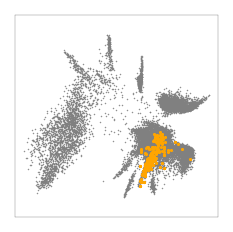

In [19]:
## Highlight the POI in 2-d layouts

mpl.rcParams['axes.linewidth'] = 0.1
methods = ['t-SNE', 'UMAP', 'ViVAE']
nmet = len(methods)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.75, 1.75), dpi=150)
fig.subplots_adjust(wspace=.05)
s = .01

emb = emb_vivae

poi = 'natural killer cell'
idcs_nk = np.where(labs==poi)[0]
for i, method in enumerate(methods):

        ax.scatter(emb[:,0], emb[:,1], s=s, c='grey', alpha=1., linewidth=.5)
        ax.scatter(emb[idcs_nk,0], emb[idcs_nk,1], s=1., c='orange', alpha=1., linewidth=.5)

        ax.axis('equal')
        ax.tick_params(axis='both', labelbottom=False, labelleft=False, bottom=False, left=False)

In [18]:
## Aggregate xNPE values for all populations for all 3 embeddings

pops = list(xnpe_tsne.keys())
methods = ['t-SNE', 'UMAP', 'ViVAE']
nmet = len(methods)
d = pd.DataFrame(
    data=np.vstack([list(xnpe_tsne.values()), list(xnpe_umap.values()), list(xnpe_vivae.values())]),
    columns=pops
)
d.index = methods
d = d.drop(unass, axis=1)
pops = list(d.keys())
npop = len(pops)

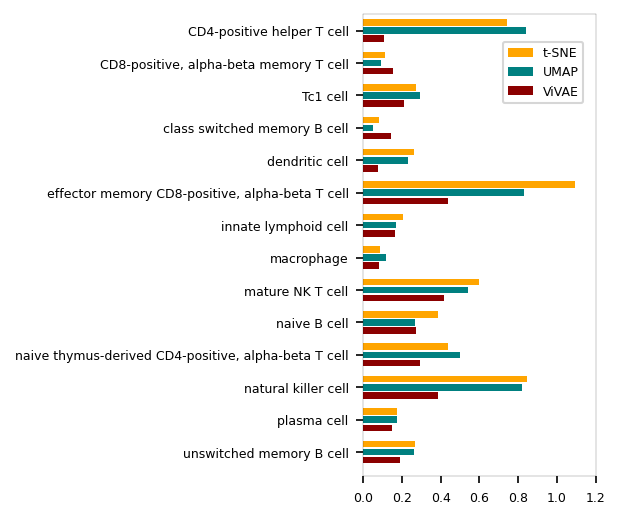

In [20]:
## Plot the xNPE values using a barplot

fig, ax = plt.subplots(figsize=(2,4), dpi=150)
mpl.rcParams['axes.linewidth'] = 0.1
pal = ['orange', 'teal', 'darkred']
n = npop*(nmet+1)

for i, method in enumerate(methods):
    for j, pop in enumerate(pops):
        if j==0:
            ax.barh(y=j*(nmet+1)+i, width=d[pop][method], color=pal[i], label=method)
        else:
            ax.barh(y=j*(nmet+1)+i, width=d[pop][method], color=pal[i])
ax.set_xlim((0., 1.2))
ax.set_ylim((-1, n))
pop_labels = copy.deepcopy(pops)
ax.set_yticks(ticks=np.arange(npop)*(nmet+1)+1, labels=pop_labels)
ax.tick_params(axis='both', labelsize=6)
plt.gca().invert_yaxis()

fig.legend(bbox_to_anchor=(.88, .845), fontsize=6)
fig.savefig('reed_C_barplot.png', bbox_inches='tight', dpi=300, transparent=True)
fig.savefig('reed_C_barplot.svg', bbox_inches='tight', transparent=True)

In [21]:
## Calculate neighbourhood compositions per population per embedding

pop      = poi
nc_hd    = vs.neighbourhood_composition(X=pc, pop=pop, annot=labs, k=1000, stepsize=10, random_state=42)
nc_tsne  = vs.neighbourhood_composition(X=emb_tsne, pop=pop, annot=labs, k=1000, stepsize=10, random_state=42)
nc_umap  = vs.neighbourhood_composition(X=emb_umap, pop=pop, annot=labs, k=1000, stepsize=10, random_state=42)
nc_vivae = vs.neighbourhood_composition(X=emb_vivae, pop=pop, annot=labs, k=1000, stepsize=10, random_state=42)

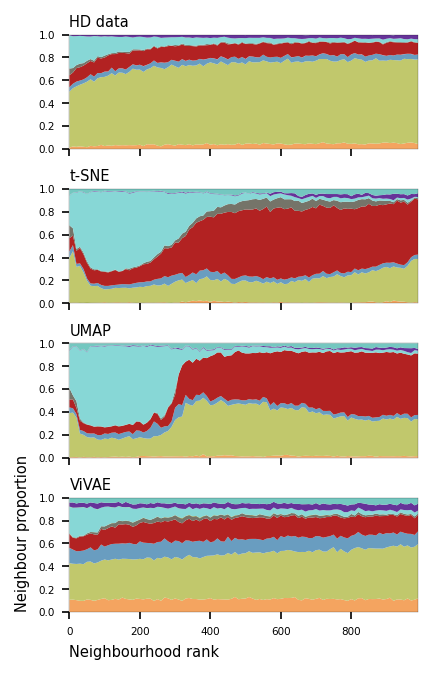

In [23]:
## Plot neighbourhood compositions

palette_without_poi = np.array(list(palette.values()))[np.where([x!=pop for x in list(palette.keys())])[0]]

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(3, 5), dpi=150, sharey=True, sharex=True)
mpl.rcParams['axes.linewidth'] = 0.1
fig.subplots_adjust(hspace=.35)

for i, nc in enumerate([nc_hd, nc_tsne, nc_umap, nc_vivae]):
    y = np.vstack(nc[3])
    ax[i].stackplot(nc[4], y.T, labels=nc[1], colors=palette_without_poi)
    ax[i].set_ylim((0.,1.))
    ax[i].set_xlim((min(nc[4]), max(nc[4])))
    ax[i].set_title(['HD data', 't-SNE', 'UMAP', 'ViVAE'][i], size=7, ha='left', x=.0, y=.96)
    ax[i].tick_params(axis='both', labelsize=5)

ax[3].set_ylabel('Neighbour proportion', loc='bottom', size=7)
ax[3].set_xlabel('Neighbourhood rank', loc='left', size=7)

fig.savefig('reed_D_ncp.png', bbox_inches='tight', dpi=300, transparent=True)
fig.savefig('reed_D_npc.svg', bbox_inches='tight', transparent=True)